In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv( "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv")

In [3]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
df['Month']=pd.to_datetime(df['Month'])

In [5]:
df.set_index('Month', inplace=True)

Text(0, 0.5, 'Passengers')

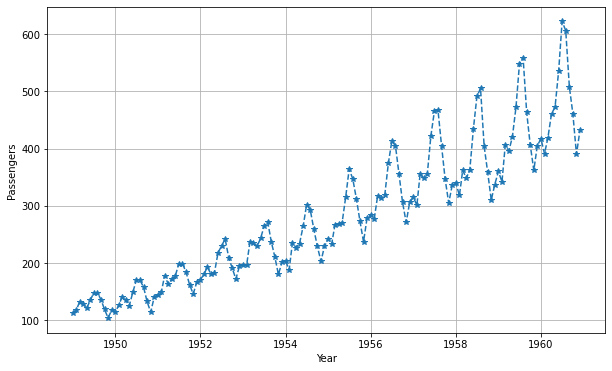

In [6]:
plt.figure(figsize=(10,6))
plt.plot(df.index, df.Passengers, '--', marker='*',)
plt.grid()
plt.xlabel('Year')
plt.ylabel('Passengers')

In [7]:
#checking for missing values
df.isnull().values.any()

False

In [8]:
#There are no missing values in our dataset however, in bid to explain how we handle
#missing values, we will make a copy of our dataset and delete some values at random.
copied_df = df.copy()
rows=copied_df.sample(frac = 0.1, random_state = 0)
rows['Passengers'] = np.nan
copied_df.loc[rows.index, 'Passengers'] = rows['Passengers']
copied_df.isnull().sum()

Passengers    14
dtype: int64

## Filling missing data by imputation

In [9]:
#fiiling missing data by forward fill
copied_df_ffill = copied_df.fillna(method='ffill')
copied_df_ffill.isnull().sum()

Passengers    0
dtype: int64

In [10]:
#filling missing data by backward fill
copied_df_bfill = copied_df.fillna(method='bfill')
copied_df_bfill.isnull().sum()

Passengers    0
dtype: int64

## Filling missing data by interpolation

In [11]:
copied_df_LIF = copied_df.interpolate(method='linear', limit_direction='forward')
copied_df_LIF.isnull().sum()

Passengers    0
dtype: int64

In [12]:
copied_df_LIB = copied_df.interpolate(method='linear', limit_direction='backward')
copied_df_LIB.isnull().sum()

Passengers    0
dtype: int64

## Downsampling and Upsampling

In [13]:
#downsample to quarterly data points
df_quarterly = df.resample('3M').mean()

In [14]:
#upsample to daily data points
df_daily = df.resample('D').mean()

Text(0.5, 1.0, 'Downsampled data')

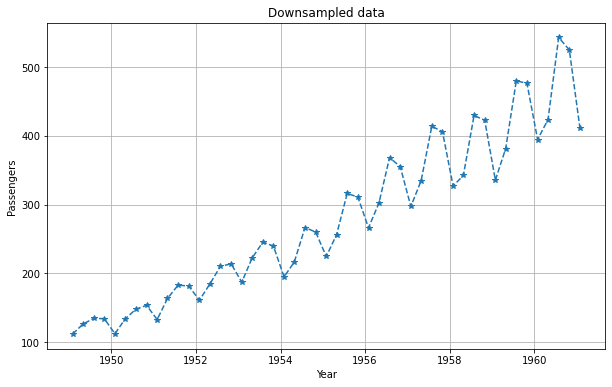

In [15]:
#downsampled data
plt.figure(figsize=(10,6))
plt.plot(df_quarterly.index, df_quarterly.Passengers, '--', marker='*',)
plt.grid()
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.title("Downsampled data")

Text(0.5, 1.0, 'Upsampled Data')

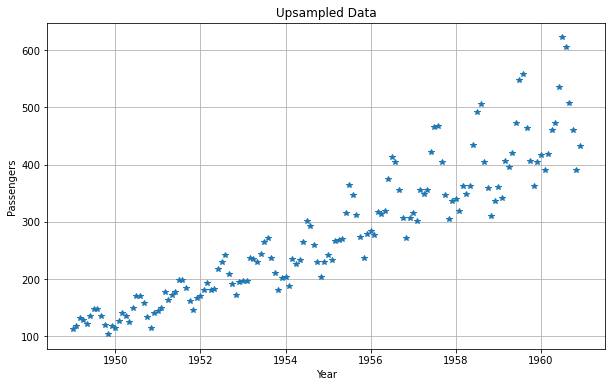

In [16]:
#upsampled data
plt.figure(figsize=(10,6))
plt.plot(df_daily.index, df_daily.Passengers, '--', marker='*',)
plt.grid()
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.title("Upsampled Data")

## Smoothing the Data

In [17]:
df_MA = df.copy()
MA = df_MA['Passengers'].rolling(12).mean()

Text(0.5, 1.0, 'Data Smoothing')

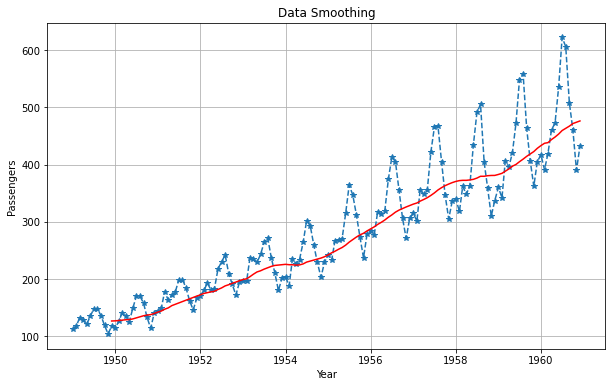

In [18]:
plt.figure(figsize=(10,6))
plt.plot(df_MA.index, df_MA.Passengers, '--', marker='*',)
plt.plot(df_MA.rolling( 12 ).mean(), color= 'red')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.title("Data Smoothing")

## Time Series Specific Exploratory Methods

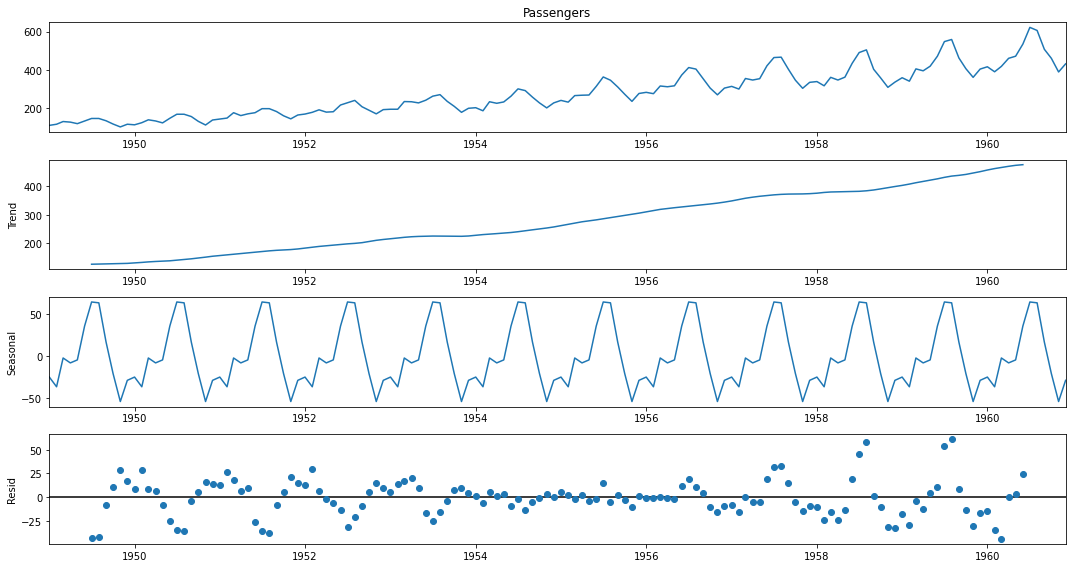

In [19]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 15 , 8
decompose_series = sm.tsa.seasonal_decompose(df[ 'Passengers' ], model= 'additive' )
decompose_series.plot()
plt.show()

In [20]:
#The decomposed time series show an obvious increasing trend and seasonality variations.
#We have initially plotted the moving average on the last 12 months which showed
#that it varies with time. This suggests that the data is not stationary. We will now perform
#an ADF test to confirm this speculation.

from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df[ 'Passengers' ])
print(f'ADF Statistic: {adf_result[ 0 ]}')
print(f'p-value: {adf_result[ 1 ]}')
print(f'No. of lags used: {adf_result[ 2 ]}')
print(f'No. of observations used : {adf_result[ 3 ]}')
print('Critical Values:')
for k, v in adf_result[ 4 ].items():
    print(f'{k} : {v}')

ADF Statistic: 0.8153688792060428
p-value: 0.9918802434376409
No. of lags used: 13
No. of observations used : 130
Critical Values:
1% : -3.4816817173418295
5% : -2.8840418343195267
10% : -2.578770059171598


Text(0.5, 1.0, 'Differenced Data')

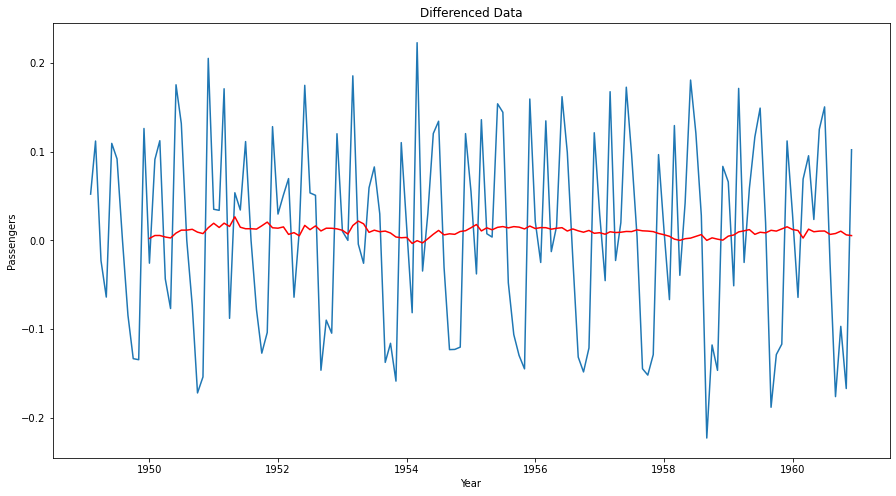

In [21]:
#From the results obtained, the p-value is greater than the critical value at a 5%
#significance level and, the ADF statistic is greater than any of the critical values obtained. 
#This confirms that the series is indeed non-stationary.

#convert time series to stationary by removing trend and seasonality

df_log = np.log(df)
df_diff = df_log.diff(periods=1)
plt.plot(df_diff.index, df_diff.Passengers, '-')
plt.plot(df_diff.rolling(12).mean(), color='red')
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.title('Differenced Data')

# Time Series forcasting using stochastic models

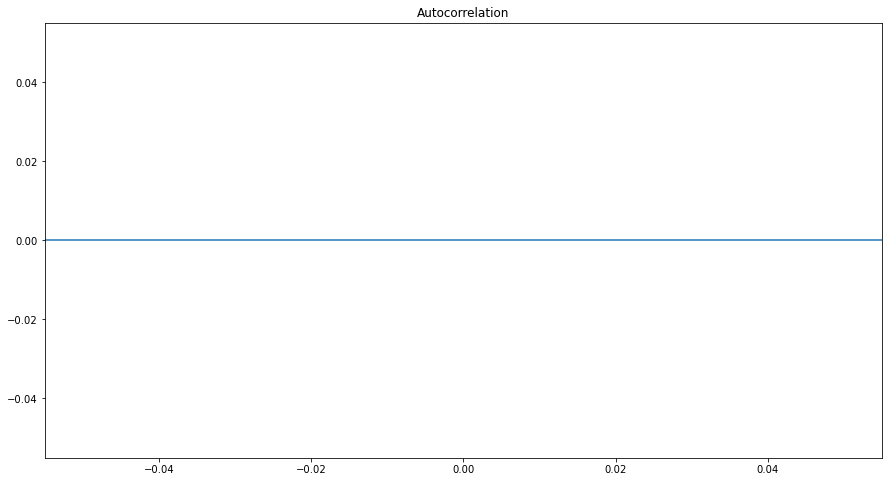

In [25]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#ACF
plot_acf(df_diff, lags = range(0, 20))
plt.show()

<Figure size 1152x432 with 0 Axes>

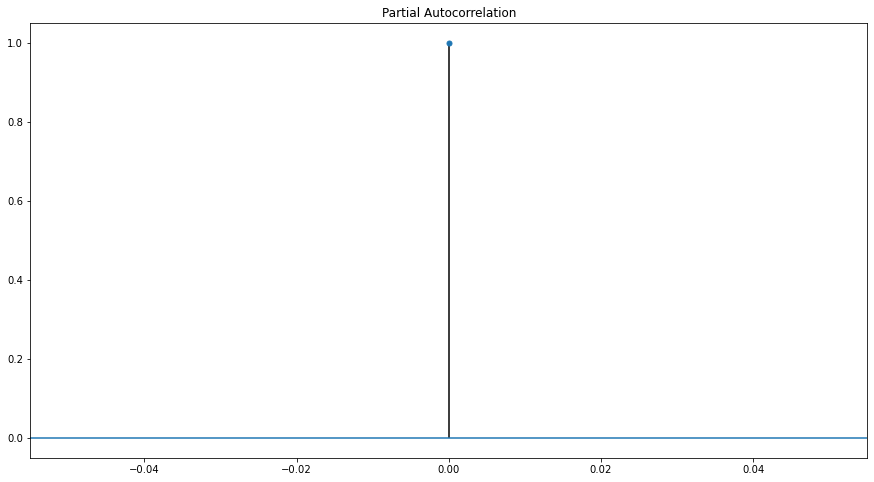

In [27]:
#PACF
plt.figure(figsize=(16, 6))
plot_pacf(df_diff, lags = range(0, 20))
plt.show()

In [36]:
#The shaded regions in the plots are the confidence intervals. The lags where the PACF 
#and ACF charts cross this region are the values for p and q respectively. In both plots, #p=q=1.
#In the ACF plot, there is one lag that crosses the significance level hence, q=1. Similarly
#in the PACF plot, p=2
df_diff.isnull().sum()
df_diff = df_diff.dropna()

C:\Users\HP\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


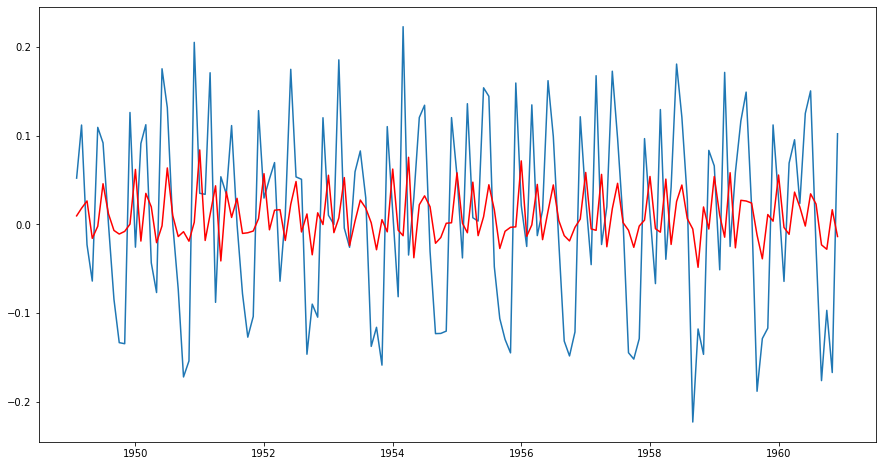

In [38]:
#AR, MA and ARIMA
from statsmodels.tsa.arima_model import ARIMA
#(p,d,q)
AR_model = ARIMA(df_diff, order=(2,0,0))
AR_model_results = AR_model.fit()
plt.plot(df_diff)
plt.plot(AR_model_results.fittedvalues, color='red')

C:\Users\HP\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


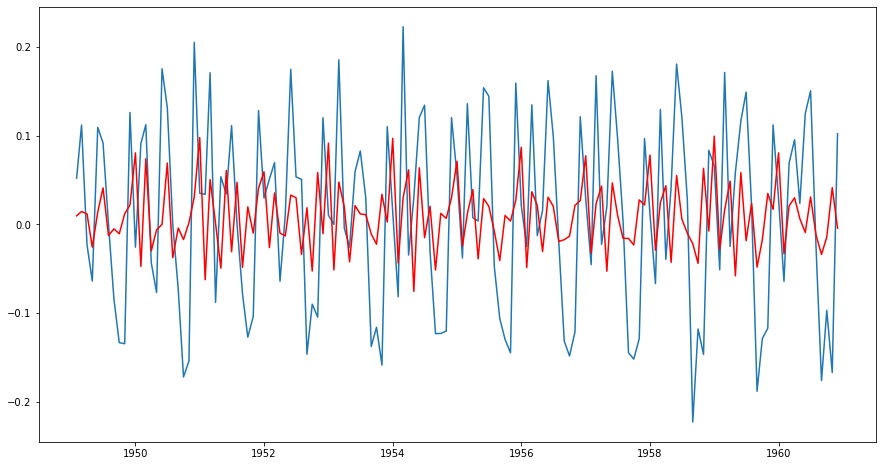

In [39]:
MA_model = ARIMA(df_diff, order=(0,0,2))
MA_model_results = MA_model.fit()
plt.plot(df_diff)
plt.plot(MA_model_results.fittedvalues, color='red')

C:\Users\HP\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


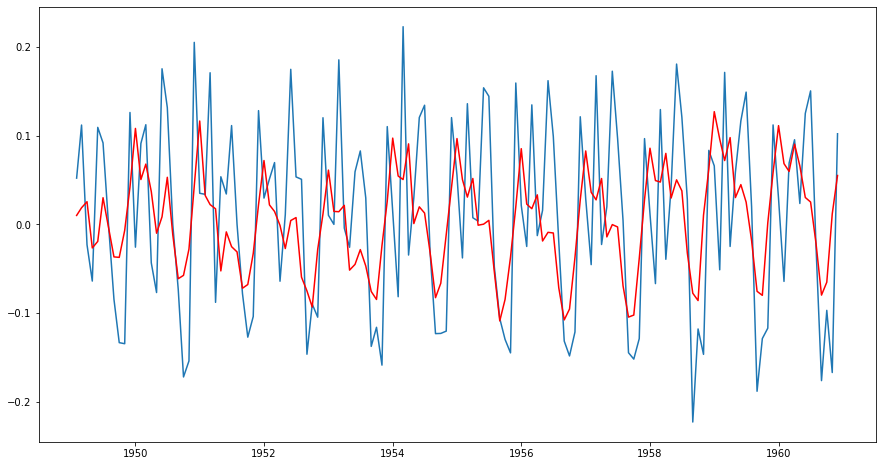

In [42]:
ARIMA_model = ARIMA(df_diff, order=(2,0,1))
ARIMA_model_results = ARIMA_model.fit()
plt.plot(df_diff)
plt.plot(ARIMA_model_results.fittedvalues, color='red')

## Time series with Facebook prophet

In [48]:
from fbprophet import Prophet
data = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv")
df['Month'] = pd.to_datetime(df['Month'])
df = df.rename(columns={"Month": "ds", "Passengers": "y"})
df.head()

ModuleNotFoundError: No module named 'fbprophet'

In [ ]:
model = Prophet()
model.fit(df)

#predict for the next 10 months
future = model.make_future_dataframe(periods=10, freq='M') 
forecast = model.predict(future) 
forecast.head()
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']]
#yhat is the prediction while yhat_lower and yhat_upper are the upper and lower boundaries